In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import tqdm
 
import Task

In [3]:
T_stim = 24
T_delay = 16
T_resp = 24
stim_dim = 36

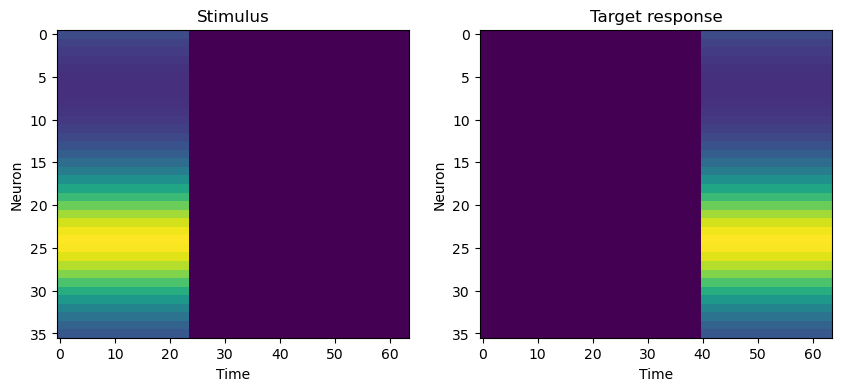

In [7]:
Task.plot_trial(T_stim=T_stim, T_delay=T_delay, T_resp=T_resp, stim_dim=stim_dim)

activation function, F
Current hidden state h_t
Current input x_t
Recurrent weights M
Feedforward weights W
Readout weights R
Biases b

y_{t+1}, h_{t+1}

\tau dh/dt = -h + F( Mh + Wx + b ) 

h_{t+1} = (1 - dt/\tau)h_t + (dt/\tau) F( M h_t + W x_t + b )


[  h_{t+1} = (1 - \alpha) h_t + \alpha F(M h_t + W x_t + b)  ]


\alpha = dt/\tau 

I'm setting my alpha to 0.25

In [14]:
class WM_RNN(nn.Module):
    def __init__(self, stim_dim, recurrent_dim, alpha):
        super(WM_RNN, self).__init__()
        self.stim_dim = stim_dim
        self.recurrent_dim = recurrent_dim
        self.alpha = alpha

        self.Layer = nn.ModuleDict({
            'Input': nn.Linear(stim_dim + 1, recurrent_dim),
            'Recurrent': nn.Linear(recurrent_dim, recurrent_dim),
            'Output': nn.Linear(recurrent_dim, stim_dim)
        })

    def forward(self, X):
        # X is a tensor of shape (batch_size, T_total, stim_dim + 1)
        batch_size = X.shape[0]
        T_total = X.shape[1]
        h = torch.zeros(batch_size, self.recurrent_dim)
        Y = torch.zeros(batch_size, T_total, self.stim_dim)
        for t in range(T_total):
            Y[:, t, :], h = self.forward_one_step(X[:, t, :], h)
        return Y

    def forward_one_step(self, x, h):
        # x is a tensor of shape (batch_size, stim_dim + 1)
        # h is a tensor of shape (batch_size, recurrent_dim)
        h_new = (1 - self.alpha) * h + self.alpha * F.relu(self.Layer['Input'](x) + self.Layer['Recurrent'](h))
        y = self.Layer['Output'](h_new)
        
        return y, h_new


my_model = WM_RNN(stim_dim=stim_dim, recurrent_dim=100, alpha=0.25)


In [15]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

In [17]:
# Train the model
losses = []
for episode in tqdm.tqdm(range(2000)):
    # Generate a batch of trials
    X, Y = Task.task(T_stim=T_stim, T_delay=T_delay, T_resp=T_resp, batch_size=32, stim_dim=stim_dim)
    # Forward pass
    Y_pred = my_model(X)
    # Compute loss
    loss = loss_function(Y_pred, Y)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Record loss
    losses.append(loss.detach().numpy())

100%|██████████| 2000/2000 [01:19<00:00, 25.19it/s]


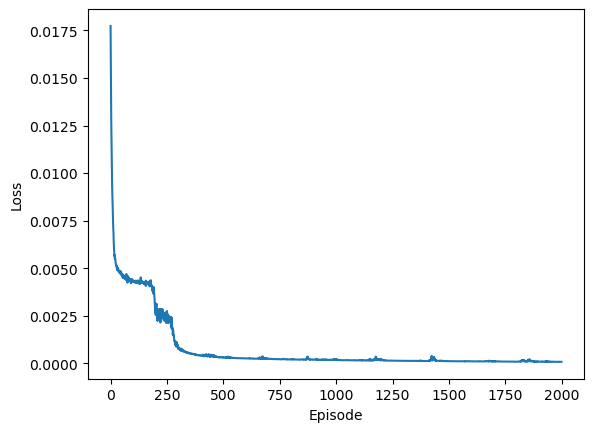

In [18]:
# Plot the loss curve
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()
